In [1]:
from glob import glob
import json
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import linregress
%matplotlib inline

In [2]:
rc("font", size=18, weight="normal")

# Global variables

In [3]:
# This first dataset, in an older format, only serves for encoding and mixer comparison
DATA_DIRECTORY1, RESULT_PATTERN1 = Path("data", "saw_backtracking_vs_non_backtracking_analysis"), "result_*json"
# The second dataset, in a newer format and using exclusively the inversion-about the mean mixer with backtracking
# encodind, allows for a more thorough analysis 
DATA_DIRECTORY2, RESULT_PATTERN2 = Path("data", "saw_general_analysis", "saw_qaoa_*_steps"), "enriched_result*json"
# The third dataset consists of parts of the second, slightly augmented to included entropy metrics on the distribution
DATA_DIRECTORY3, RESULT_PATTERN3 = Path("data", "saw_general_analysis", "saw_qaoa_*_steps_with_entropy"), "enriched_result*json"

# Helper functions

In [4]:
def load_results(DATA_DIRECTORY, RESULT_PATTERN, with_entropy=False):
    results = []
    result_files = glob(str(Path(DATA_DIRECTORY, RESULT_PATTERN)))
    max_num_crossings = 0
    for result_file in result_files:
        with Path(result_file).open("r") as f:
            result = json.load(f)
            for idx, opt_result in enumerate(result["angles"]):
                record = dict(result)
                del record["angles"]
                del record["betas"]
                del record["gammas"]
                del record["output-dir"]
                del record["pextrap"]
                del record["pmin"]
                del record["pmax"]
                record["p"] = result["pmin"] + idx
                record["angles"] = opt_result[0]
                record["expected_energy"] = opt_result[1]
                record["success_probability"] = opt_result[2]
                record["expected_energy_random"] = record["random_sampling"][0]
                record["success_probability_random"] = record["random_sampling"][1]
                if with_entropy:
                    max_num_crossings = max(max_num_crossings, len(opt_result) - 6)
                    for num_crossings in range(1, len(opt_result) - 5):
                        record[f"{num_crossings}_self_crossings_probability"] = opt_result[2 + num_crossings]
                    record["loop_probability"] = opt_result[-3]
                    record["collision_entropy"] = opt_result[-2]
                    record["entropy"] = opt_result[-1]
                else:
                    max_num_crossings = max(max_num_crossings, len(opt_result) - 4)
                    for num_crossings in range(1, len(opt_result) - 3):
                        record[f"{num_crossings}_self_crossings_probability"] = opt_result[2 + num_crossings]
                    record["loop_probability"] = opt_result[-1]
                record["runtime"] /= record["num-trials"]
                del record["random_sampling"]
                record["extrap"] = record["p"] >= result["pextrap"]
                results.append(record)
    results_df = pd.DataFrame(results).fillna({f"{num_crossings}_self_crossings_probability": 0 for num_crossings in range(1, max_num_crossings + 1)})
    parameters_fields = ["num-steps", "loop-penalty", "non-backtracking", "mixer", "p"]
    result_fields = [
        "runtime",
        "expected_energy_random",
        "expected_energy",
        "success_probability_random",
        "success_probability",
        "angles",
        "loop_probability"
    ] + (
        ["collision_entropy", "entropy"] if with_entropy else []
    ) + [
        f"{num_crossings}_self_crossings_probability" for num_crossings in range(1, max_num_crossings + 1)
    ]
    best_results_df = results_df \
        .sort_values("expected_energy") \
        .drop_duplicates(parameters_fields, keep="first") \
        .sort_values(parameters_fields)
    best_results_df = best_results_df[parameters_fields + result_fields]
    best_results_without_extrap_df = results_df \
        .query("extrap == False") \
        .sort_values("expected_energy") \
        .drop_duplicates(parameters_fields, keep="first") \
        .sort_values(parameters_fields)
    best_results_without_extrap_df = best_results_without_extrap_df[parameters_fields + result_fields]
    results_count_df = results_df.groupby(parameters_fields).agg({"num-trials": "sum", "runtime": "mean"}).reset_index()
    results_count_df = results_count_df[parameters_fields + ["num-trials", "runtime"]]
    return best_results_df, best_results_without_extrap_df, results_count_df

# Paper plots

## Encoding and mixer comparison

### Local parameters

In [5]:
num_steps = 10

### Plots and tables generation

In [6]:
best_results_df, best_results_without_extrap_df, results_count_df = load_results(DATA_DIRECTORY1, RESULT_PATTERN1)

Non-backtracking: False
mixer: qudit_x


,num-steps,loop-penalty,non-backtracking,mixer,p,runtime,expected_energy_random,expected_energy,success_probability_random,success_probability,angles,loop_probability
3441,10,0.2,False,qudit_x,2,38.553257,4.697876,2.045700,0.000671,0.020656,"[-1.137328883138616, -43.63060674416477, 9.410...",0.020656
4822,10,0.2,False,qudit_x,3,73.855134,4.697876,1.589044,0.000671,0.035644,"[0.9096045258837453, -6.6426859151173145, -0.0...",0.035644
107,10,0.2,False,qudit_x,4,88.899460,4.697876,1.275929,0.000671,0.063091,"[0.7944534915083722, -0.357016534688982, 3.141...",0.063091
4818,10,0.2,False,qudit_x,5,176.980624,4.697876,1.183111,0.000671,0.072128,"[-0.7061879206833717, -2.7970028301529144, -3....",0.072128


mixer: grover


,num-steps,loop-penalty,non-backtracking,mixer,p,runtime,expected_energy_random,expected_energy,success_probability_random,success_probability,angles,loop_probability
1351,10,0.2,False,grover,2,21.681503,4.697876,2.057660,0.000671,0.020580,"[1.1393226799551668, -0.3424762615193071, 1.76...",0.020580
469,10,0.2,False,grover,3,45.769226,4.697876,1.602028,0.000671,0.035489,"[-0.9198227762978638, 0.33848013470059524, -1....",0.035489
764,10,0.2,False,grover,4,62.714812,4.697876,1.292819,0.000671,0.062060,"[0.8025888033570578, -0.339363295351901, 1.164...",0.062060
437,10,0.2,False,grover,5,129.983404,4.697876,1.059097,0.000671,0.104183,"[0.6891345672637533, -0.3431112587281513, 1.02...",0.104183
1001,10,0.2,False,grover,6,141.493850,4.697876,0.870386,0.000671,0.164036,"[0.6038691123628476, -0.347514303927865, 0.896...",0.164036
4918,10,0.2,False,grover,7,198.298361,4.697876,0.720663,0.000671,0.230937,"[0.5300161675451946, -0.3473060313427565, 0.78...",0.230937
1343,10,0.2,False,grover,8,292.708961,4.697876,0.599196,0.000671,0.296081,"[-0.47315864241484845, 0.349589938120797, -0.6...",0.296081
5778,10,0.2,False,grover,9,93.615620,4.697876,0.500836,0.000671,0.353007,"[0.42243904788285835, -0.3507147537077233, 0.6...",0.353007
5779,10,0.2,False,grover,10,93.615620,4.697876,0.424248,0.000671,0.403065,"[0.37230427368088725, -0.353052719555349, 0.55...",0.403065


mixer: qubit_x


,num-steps,loop-penalty,non-backtracking,mixer,p,runtime,expected_energy_random,expected_energy,success_probability_random,success_probability,angles,loop_probability
2390,10,0.2,False,qubit_x,2,23.036371,4.697876,2.251313,0.000671,0.016038,"[-1.1232134801229297, 0.49801585529078807, -1....",0.016038
2389,10,0.2,False,qubit_x,3,36.065295,4.697876,1.807384,0.000671,0.029084,"[0.8539826486558781, -0.48392159804256796, 1.2...",0.029084
3935,10,0.2,False,qubit_x,4,64.659391,4.697876,1.498775,0.000671,0.047810,"[-0.7233121109727007, 0.47462360351580735, -1....",0.047810
4311,10,0.2,False,qubit_x,5,96.107917,4.697876,1.318132,0.000671,0.069438,"[-0.5693483990260423, -2.6543797730315917, -0....",0.069438
1906,10,0.2,False,qubit_x,6,657.050695,4.697876,1.123012,0.000671,0.096872,"[-0.4966938125553194, -2.6450673705815024, -0....",0.096872
1907,10,0.2,False,qubit_x,7,657.050695,4.697876,0.971015,0.000671,0.125594,"[-0.43392999154927936, -2.6392712733129655, -0...",0.125594
1908,10,0.2,False,qubit_x,8,657.050695,4.697876,0.849625,0.000671,0.153133,"[-0.3798184481301478, -2.6442341614903073, -0....",0.153133
1909,10,0.2,False,qubit_x,9,657.050695,4.697876,0.753605,0.000671,0.178779,"[-0.33071610619788866, -2.656628286988334, -0....",0.178779
1910,10,0.2,False,qubit_x,10,657.050695,4.697876,0.676483,0.000671,0.202112,"[-0.28929841001385875, -2.673319584920938, -0....",0.202112


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


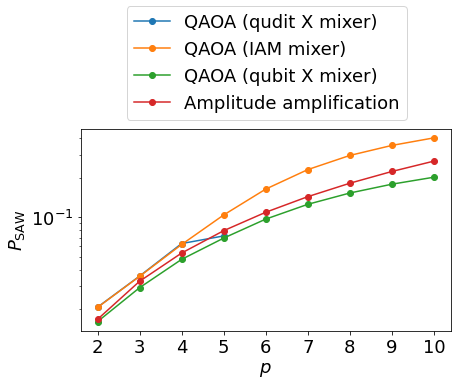

Non-backtracking: True
mixer: qudit_x


,num-steps,loop-penalty,non-backtracking,mixer,p,runtime,expected_energy_random,expected_energy,success_probability_random,success_probability,angles,loop_probability
253,10,0.2,True,qudit_x,2,31.884739,4.169425,1.537929,0.006706,0.052909,"[0.5795239766455733, -0.3149021438689122, 6.25...",0.052909
3379,10,0.2,True,qudit_x,3,41.000585,4.169425,1.220876,0.006706,0.069124,"[0.4848807538721736, 5.951569967027869, -0.010...",0.069124
2892,10,0.2,True,qudit_x,4,73.955914,4.169425,1.003714,0.006706,0.093838,"[-0.4165172110232402, -5.948091590009264, -6.2...",0.093838
123,10,0.2,True,qudit_x,5,127.669999,4.169425,0.841957,0.006706,0.129557,"[-0.37401739210364854, -2.805948563211179, -0....",0.129557


mixer: grover


,num-steps,loop-penalty,non-backtracking,mixer,p,runtime,expected_energy_random,expected_energy,success_probability_random,success_probability,angles,loop_probability
3500,10,0.2,True,grover,2,17.313990,4.169425,1.538979,0.006706,0.052699,"[-0.5790376441817922, 0.30149430715762904, -1....",0.052699
4511,10,0.2,True,grover,3,30.046707,4.169425,1.221172,0.006706,0.069057,"[0.48487035169974263, -0.3262976312917294, 0.9...",0.069057
36,10,0.2,True,grover,4,48.721973,4.169425,1.004382,0.006706,0.093745,"[0.4165882272874284, -0.3378752929939639, 0.84...",0.093745
5319,10,0.2,True,grover,5,598.091637,4.169425,0.842680,0.006706,0.129094,"[0.37353678304340915, -0.33856925910948554, 0....",0.129094
5320,10,0.2,True,grover,6,598.091637,4.169425,0.719099,0.006706,0.182363,"[0.342539477550696, -0.34871786366805324, 0.67...",0.182363
5321,10,0.2,True,grover,7,598.091637,4.169425,0.616406,0.006706,0.206187,"[0.32046309456932653, -0.35593200879891995, 0....",0.206187
5322,10,0.2,True,grover,8,598.091637,4.169425,0.534866,0.006706,0.259808,"[0.2865958206204128, -0.36606972171016783, 0.5...",0.259808
5323,10,0.2,True,grover,9,598.091637,4.169425,0.468430,0.006706,0.310186,"[0.2607705676134523, -0.3718621044370183, 0.53...",0.310186
5324,10,0.2,True,grover,10,598.091637,4.169425,0.414901,0.006706,0.357232,"[0.24175047062270008, -0.37413757267091174, 0....",0.357232


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


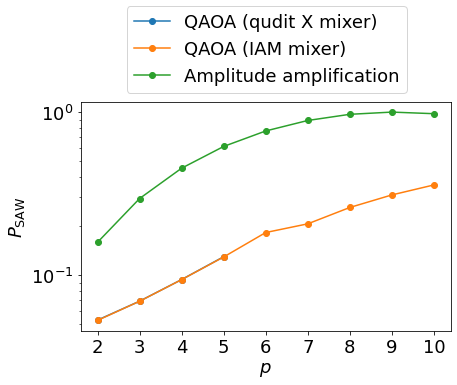

In [7]:
for non_backtracking in [False, True]:
    print(f"Non-backtracking: {non_backtracking}")
    ax = plt.figure(figsize=(6.7, 5.7)).gca()
    for mixer, mixer_legend in [("qudit_x", "QAOA (qudit X mixer)"), ("grover", "QAOA (IAM mixer)")] + ([("qubit_x", "QAOA (qubit X mixer)")] if not non_backtracking else []):
        print(f"mixer: {mixer}")
        selected_df = best_results_df[
            (best_results_df["num-steps"] == num_steps) &
            (best_results_df["non-backtracking"] == non_backtracking) &
            (best_results_df["mixer"] == mixer)
        ]
        display(selected_df)
        plt.semilogy(selected_df["p"], selected_df["success_probability"], "o-", label=mixer_legend)
    plt.semilogy(selected_df["p"], np.sin((2 * selected_df["p"] + 1) * np.arcsin(np.sqrt(selected_df.iloc[0]["success_probability_random"]))) ** 2, "o-", label="Amplitude amplification")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("$p$")
    plt.ylabel("$P_{\mathrm{SAW}}$")
    plt.legend(loc="lower left", bbox_to_anchor=(0.1, 1.0))
    plt.tight_layout()
    plt.savefig(Path("figures", "saw", f"mixer_comparison__num_steps_{num_steps}__non_backtracking_{non_backtracking}.eps"))
    plt.show()

## Probability of self-avoiding loop versus ansatz depth $p$ and number of steps

### Data loading

In [8]:
best_results_df, best_results_without_extrap_df, results_count_df = load_results(DATA_DIRECTORY2, RESULT_PATTERN2)

### Ansatz depth $p$ vs. success probability

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


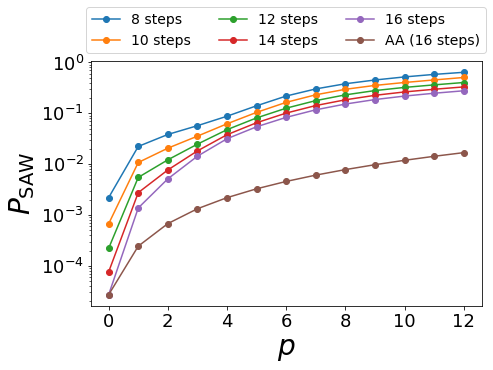

In [9]:
selected_df = best_results_df.query("mixer == 'grover' and p <= 12")
ax = plt.figure(figsize=(7, 4.5)).gca()
for num_steps in selected_df["num-steps"].unique():
    selected_df2 = selected_df.query(f"`num-steps` == {num_steps}")
    ax.semilogy(np.concatenate(([0], selected_df2["p"])), np.concatenate(([selected_df2["success_probability_random"].iloc[0]], selected_df2["success_probability"])), "o-", label=f"{num_steps} steps")
max_num_steps = max(selected_df["num-steps"])
max_num_steps_result = selected_df.query(f"`num-steps` == {num_steps}")
ax.semilogy(np.concatenate(([0], selected_df2["p"])), np.sin((2 * np.concatenate(([0], selected_df2["p"])) + 1) * np.arcsin(np.sqrt(selected_df2["success_probability_random"].iloc[0]))) ** 2, "o-", label=f"AA ({num_steps} steps)")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("$p$", fontsize=28)
ax.set_ylabel("$P_{\mathrm{SAW}}$", fontsize=28)
plt.legend(fontsize=14, loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3)
plt.savefig(Path("figures", "saw", "success_probability_grover_mixer_backtracking.eps"), bbox_inches="tight")

### Number of steps vs. success probability

random | linregress result: LinregressResult(slope=-0.2382348030242773, intercept=-0.7757164292426468, rvalue=-0.999635138921079, pvalue=1.1162925823858322e-92, stderr=0.0008452571338270809, intercept_stderr=0.010421029823746158)
p = 1 | linregress result: LinregressResult(slope=-0.15065587509662595, intercept=-0.4530721618689322, rvalue=-0.9999410136782121, pvalue=5.43822269934557e-07, stderr=0.0009447900578492096, intercept_stderr=0.011648154124943074)
p = 4 | linregress result: LinregressResult(slope=-0.055008018151949625, intercept=-0.6420150755145049, rvalue=-0.9927627561887788, pvalue=0.0007382809068268851, stderr=0.0038417959604674645, intercept_stderr=0.04736484163051057)
p = 16 | linregress result: LinregressResult(slope=-0.04182306603880356, intercept=0.26979356291397166, rvalue=-0.9885565898942035, pvalue=0.0014669664254222086, stderr=0.00368468539739237, intercept_stderr=0.04542785252044166)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


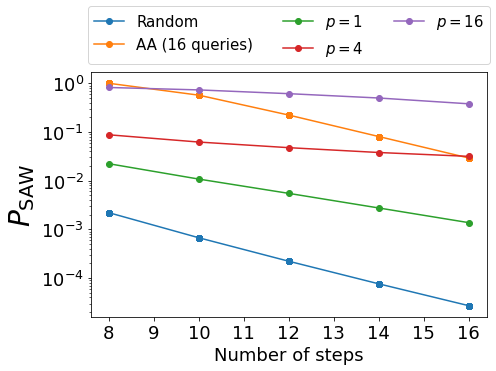

In [10]:
ax = plt.figure(figsize=(7.2, 5.8)).gca()
ax.semilogy(selected_df["num-steps"], selected_df["success_probability_random"], "o-", label="Random")
linreg_result = linregress(selected_df["num-steps"], np.log10(selected_df["success_probability_random"]))
ax.semilogy(selected_df["num-steps"], np.sin((2 * 16 + 1) * np.arcsin(np.sqrt(selected_df["success_probability_random"]))) ** 2, "o-", label="AA (16 queries)")
print(f"random | linregress result: {linreg_result}")
for p in [1, 4, 16]:
    selected_df = best_results_df.query(f"mixer == 'grover' and p == {p}")
    ax.semilogy(selected_df["num-steps"], selected_df["success_probability"], "o-", label=f"$p = {p}$")
    linreg_result = linregress(selected_df["num-steps"], np.log10(selected_df["success_probability"]))
    print(f"p = {p} | linregress result: {linreg_result}")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Number of steps")
ax.set_ylabel("$P_{\mathrm{SAW}}$", fontsize=28)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), fontsize=15, ncol=3)
plt.tight_layout()
plt.savefig(Path("figures", "saw", "saw_probability_scaling.eps"))
plt.show()

### Probability distribution of number of self-crossings

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


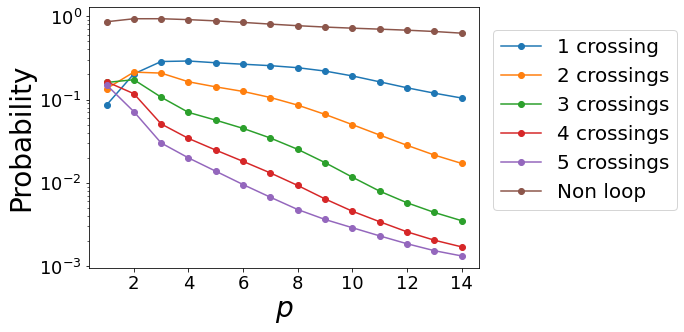

In [11]:
num_steps = 16

selected_df = best_results_df.query(f"mixer == 'grover' and `num-steps` == {num_steps} and p <= 14")
ax = plt.figure(figsize=(7, 4.8)).gca()
for num_crossings in range(1, 6):
    if np.allclose(selected_df[f"{num_crossings}_self_crossings_probability"], 0):
        continue
    ax.semilogy(selected_df["p"], selected_df[f"{num_crossings}_self_crossings_probability"], "o-", label=f"{num_crossings} crossing{'s' if num_crossings > 1 else ''}")
    #plt.plot(selected_df["p"], np.sin((2 * selected_df["p"] + 1) * np.arcsin(np.sqrt(selected_df.iloc[0]["success_probability_random"]))) ** 2, "o-", label="AA")
ax.semilogy(selected_df["p"], 1 - selected_df["loop_probability"], "o-", label="Non loop")
ax.set_xlabel("$p$", fontsize=28)
ax.set_ylabel("Probability", fontsize=28)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(fontsize=20, loc="upper center", bbox_to_anchor=(1.27, 0.95))
plt.savefig(Path("figures", "saw", f"proba_dist_num_clashes__num_steps={num_steps}.eps"), bbox_inches="tight")

## Success probability with or without extrapolation

### Parameters

In [12]:
num_steps = 12

### Compare success probabilities with or without extrapolation for increasing ansatz depth $p$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


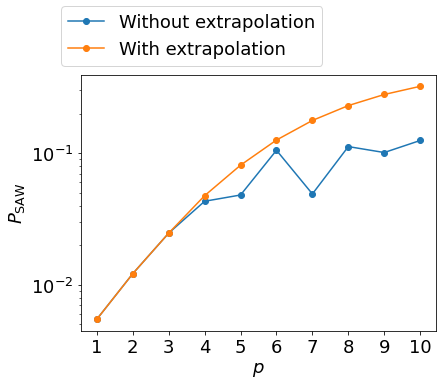

In [13]:
ax = plt.figure(figsize=(6.5, 5.7)).gca()
selected_df = best_results_without_extrap_df[
    (best_results_without_extrap_df["num-steps"] == num_steps) &
    (best_results_without_extrap_df["non-backtracking"] == False) &
    (best_results_without_extrap_df["mixer"] == "grover") &
    (best_results_without_extrap_df["p"] <= 10)
]
plt.semilogy(selected_df["p"], selected_df["success_probability"], "o-", label="Without extrapolation")
selected_df = best_results_df[
    (best_results_df["num-steps"] == num_steps) &
    (best_results_df["non-backtracking"] == False) &
    (best_results_df["mixer"] == "grover") &
    (best_results_df["p"] <= 10)
]
plt.semilogy(selected_df["p"], selected_df["success_probability"], "o-", label="With extrapolation")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("$p$")
plt.ylabel("$P_{\mathrm{SAW}}$")
plt.legend(loc="lower left", bbox_to_anchor=(-0.08, 1.0))
plt.tight_layout()
plt.savefig(Path("figures", "saw", f"with_without_extrapolation__num_steps_{num_steps}__mixer_grover__non_backtracking_{False}.eps"))

## Optimal QAOA angles

### Parameters

In [14]:
num_steps = 10

### $\beta$

/tmp/ipykernel_12509/4220638220.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4220638220.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4220638220.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4220638220.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4220638220.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backen

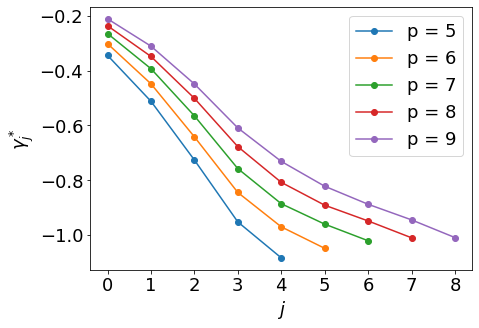

In [15]:
ax = plt.figure(figsize=(7, 4.9)).gca()
selected_df = best_results_df[
    (best_results_df["num-steps"] == num_steps) &
    (best_results_df["non-backtracking"] == False) &
    (best_results_df["mixer"] == "grover")
]
for p in range(5, 10):
    p_result = selected_df[best_results_df["p"] == p].iloc[0]
    angles = np.array(p_result["angles"])
    if angles[0] > 0:
        angles = -angles
    plt.plot(angles[0::2], "-o", label=f"p = {p}")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("$j$")
plt.ylabel("$\gamma^*_j$")
plt.legend()
plt.tight_layout()
plt.savefig(Path("figures", "saw", f"optimal_angles_gammas__num_steps_{num_steps}.eps"))

/tmp/ipykernel_12509/4145645371.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4145645371.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
/tmp/ipykernel_12509/4145645371.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_result = selected_df[best_results_df["p"] == p].iloc[0]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


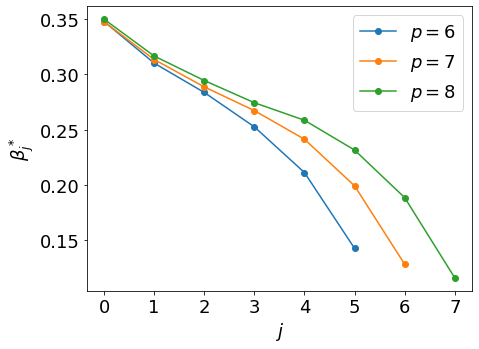

In [16]:
ax = plt.figure(figsize=(7, 5.2)).gca()
selected_df = best_results_df[
    (best_results_df["num-steps"] == num_steps) &
    (best_results_df["non-backtracking"] == False) &
    (best_results_df["mixer"] == "grover")
]
for p in range(6, 9):
    p_result = selected_df[best_results_df["p"] == p].iloc[0]
    angles = np.array(p_result["angles"])
    if angles[1] < 0:
        angles = -angles
    plt.plot(angles[1::2], "-o", label=f"$p = {p}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("$j$")
plt.ylabel("$\\beta^*_j$")
plt.legend()
plt.tight_layout()
plt.savefig(Path("figures", "saw", f"optimal_angles_betas__num_steps_{num_steps}.eps"))

## Entropy analysis

In [17]:
num_steps = 12

### Load data

In [18]:
best_results_df, best_results_without_extrap_df, results_count_df = load_results(DATA_DIRECTORY3, RESULT_PATTERN3, with_entropy=True)

### Collision entropy vs. $p$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


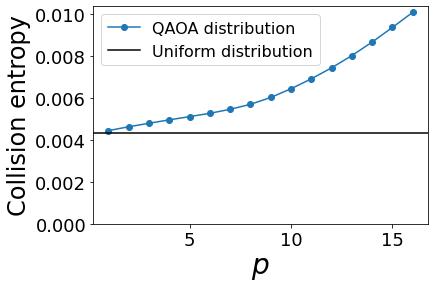

In [19]:
selected_df = best_results_df.query(f"mixer == 'grover' and `num-steps` == {num_steps}")
ax = plt.figure().gca()
ax.plot(selected_df["p"], selected_df["collision_entropy"], "o-", label="QAOA distribution")
ax.axhline(1 / (2 ** (2 * (num_steps - 2)) * selected_df.iloc[0]["success_probability_random"]), color="k", label=("Uniform distribution"))
ax.set_xlabel("$p$", fontsize=28)
ax.set_ylabel("Collision entropy", fontsize=24)
ax.set_ylim(bottom=0)
ax.legend(loc="upper left", fontsize=16)
plt.savefig(Path("figures", "saw", f"collision_entropy__num_steps={num_steps}.eps"), bbox_inches="tight")

### Entropy vs. $p$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


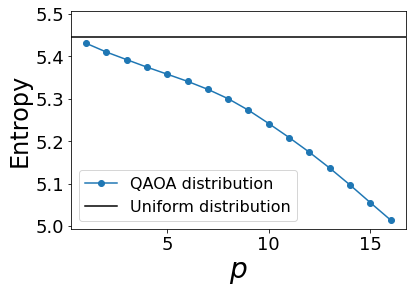

In [20]:
selected_df = best_results_df.query(f"mixer == 'grover' and `num-steps` == {num_steps}")
ax = plt.figure().gca()
ax.plot(selected_df["p"], selected_df["entropy"], "o-", label="QAOA distribution")
ax.axhline(np.log(2 ** (2 * (num_steps - 2)) * selected_df.iloc[0]["success_probability_random"]), color="k", label=("Uniform distribution"))
ax.set_xlabel("$p$", fontsize=28)
ax.set_ylabel("Entropy", fontsize=24)
ax.set_ylim(top=ax.get_ylim()[1] * 1.01)
ax.legend(loc="lower left", fontsize=16)
plt.savefig(Path("figures", "saw", f"entropy__num_steps={num_steps}.eps"), bbox_inches="tight")